In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')
if not os.path.isdir('early_stopped'):
    os.makedirs('early_stopped')

In [2]:
# scaler for data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
NUM_CLASSES = 3

epochs = 1500
batch_size = 32
num_neurons = 10
num_folds=5
seed = 10

num_attributes = 21

weight_decay = 1e-6

np.random.seed(seed)
tf.random.set_seed(seed)

histories={}

In [4]:
dataset = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
X, Y = dataset[1:,:21], dataset[1:,-1].astype(int)
Y = Y - 1 #For python that start from 0

#Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed, shuffle=True)

#Scale based on training set 
X_test = scale(X_test,np.min(X_train,axis = 0),np.max(X_train, axis=0))
X_train = scale(X_train, np.min(X_train, axis = 0),np.max(X_train, axis = 0 ))

In [5]:
#Define K fold
kfold = KFold(n_splits=num_folds,shuffle=True,random_state = seed)

def build_model():
    #Model definition
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, activation = 'relu',input_dim = num_attributes,kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(keras.layers.Dense(num_neurons, activation = 'relu',kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(keras.layers.Dense(NUM_CLASSES, activation ='softmax'))

    #default of sgd is lr = 0.01 so no need specify
    model.compile(optimizer='sgd',
                 loss = keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    
    return model

In [6]:
fold = 0
model_accuracies = []
model_losses = []

for train_idx, test_idx in kfold.split(X_train,Y_train):
        fold_csv_logger = keras.callbacks.CSVLogger('./early_stopped/5A_fold_%s.csv' % (fold))
        #to prevent overfitting, use early callbacks
        early_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20)
        callbacks = [fold_csv_logger,early_callback]
        #Build model and fit for training
        model = build_model()
        results = model.fit(X_train[train_idx],Y_train[train_idx],
                                                   validation_data = (X_train[test_idx],Y_train[test_idx]),
                                                   epochs = epochs,
                                                   verbose = 0,
                                                   batch_size=batch_size,
                                                   callbacks=callbacks)
        
        best_accuracy = max(results.history['val_accuracy'])
        best_loss = min(results.history['val_loss'])
        
        #Evaluate only by models
        print("Best accuracy of 4 layers, fold %s: %.4f" %(fold,best_accuracy))
        
        model_accuracies.append(best_accuracy*100)
        model_losses.append(best_loss)
        
        fold += 1 #Update fold number
        
print("%.2f%% (+/- %.2f%%)"%(np.mean(model_accuracies),np.std(model_accuracies)))

Best accuracy of 4 layers, fold 0: 0.8993
Best accuracy of 4 layers, fold 1: 0.9396
Best accuracy of 4 layers, fold 2: 0.8859
Best accuracy of 4 layers, fold 3: 0.9158
Best accuracy of 4 layers, fold 4: 0.8956
90.73% (+/- 1.88%)


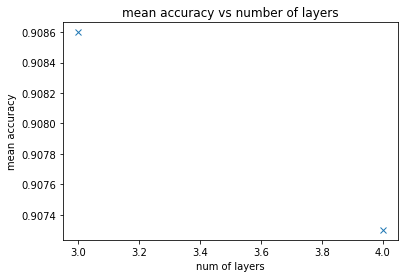

In [7]:
#From question 4, the optimal 3 layer model 5 fold statistics are
#[0.9027,0.9463,0.8993,0.9057,0.8990], mean = 0.9086
plt.plot([3,4],[0.9086,0.9073],linestyle='None',marker = 'x')
plt.title('mean accuracy vs number of layers')
plt.ylabel('mean accuracy')
plt.xlabel('num of layers')
plt.savefig('./early_stopped/mean_accuracy.png')
plt.show()